In [33]:
import pandas as pd

df = pd.read_csv("../data/review_rating.csv")

In [34]:
len(df)

86141

In [35]:
# 중복되지 않은 데이터 확인
df['1'].nunique(), df['0'].nunique()
# 중복값이 약 700개

(67095, 10)

In [36]:
df.duplicated().sum()

17027

In [37]:
#중복값 제거
df.drop_duplicates(inplace=True)
len(df)

69114

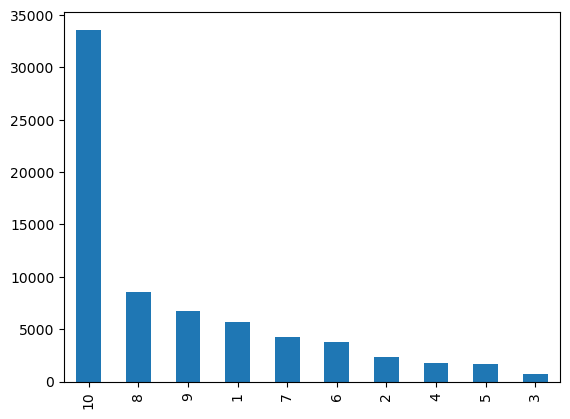

In [38]:
import matplotlib.pyplot as plt
df['0'].value_counts().plot(kind = 'bar')
plt.show()

In [39]:
#특수문자,기호 제거
df['1'] = df['1'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
df[:3]

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_15524\789926941.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['1'] = df['1'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")


,0,1,2,3,4
0,10,이 영화의 속편은 100 성공이다 원래 한국영화들 속편은 잘 안되고 속편 나오면 망...,0,범죄도시2,8.99
1,10,시리즈로 계속 나왔으면 좋겠다 마동석한테 최적화된 작품이다,0,범죄도시2,8.99
2,8,니가 강해상이냐 아뇨 구씬데요,0,범죄도시2,8.99


In [40]:
import numpy as np
#공백 제거
df['1'] = df['1'].str.replace('^ +', "")
df['1'].replace('', np.nan, inplace=True)
df.isnull().sum()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_15524\3960239143.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['1'] = df['1'].str.replace('^ +', "")


0      0
1    990
2      0
3      0
4      0
dtype: int64

In [41]:
df.loc[df['1'].isnull()][:3]

,0,1,2,3,4
1381,8,NaN,30,듄,8.83
1540,2,NaN,31,앤트맨과 와스프: 퀀텀매니아,6.86
2129,6,NaN,53,킹메이커,8.08


In [42]:
#null 샘플 제거
df = df.dropna(how = 'any')
len(df)

68124

In [43]:
# 불용어 사전
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [44]:
from sklearn.model_selection import train_test_split

y = df['0']
X = df['1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [45]:
from konlpy.tag import Okt
okt = Okt()
X_train_lis = []
#형태소 분석
for sentence in X_train:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train_lis.append(temp_X)

In [46]:
print(X_train_lis[:3])

[['1', '편도', '재미', '잇다', '엇', '늘다', '영화', '재미', '잇다'], ['옆', '에서', '우리', '오빠', '나다', '언', '젠', '간', '꼭', '에베레스트', '등반', '민폐', '끼치다', '따다', '집', '얌전하다', '들다', '앉다', '랬', '다'], ['내', '이상하다', '건가', '디즈니', '애니메이션', '중', '에서', '소름', '안', '돋다', '하나', '없다', '하', '쿠나', '마타', '타', '에서', '심바', '크다', '장면', '이란', '또', '벌레', '맛있다', '보이', '기다', '처음', '인', '듯']]


In [47]:
from konlpy.tag import Okt
okt = Okt()
X_test_lis = []
#형태소 분석
for sentence in X_test:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test_lis.append(temp_X)

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lis)
#print(tokenizer.word_index)

In [49]:
# 출현빈도가 3회 미만인 단어들
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어수
rare_cnt = 0
total_freq = 0
rare_freq = 0
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print(total_cnt) #단어집합 크기
print(rare_cnt) #희귀단어수

29465
15989


In [50]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 13477


In [51]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_lis) #텍스트를 숫자 시퀀스로 변환
X_train = tokenizer.texts_to_sequences(X_train_lis)
X_test = tokenizer.texts_to_sequences(X_test_lis)

In [52]:
print(X_train[:3])

[[95, 1584, 113, 841, 2746, 369, 1, 113, 841], [1093, 15, 86, 2747, 99, 1229, 1289, 392, 94, 4791, 6750, 3019, 2932, 680, 310, 48, 972, 7952, 16], [37, 520, 878, 889, 474, 70, 15, 496, 38, 641, 84, 8, 146, 11244, 718, 15, 9845, 136, 58, 347, 132, 3689, 1833, 851, 384, 103, 25, 108]]


In [53]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [54]:
max_len=max(len(l) for l in X_train) #리뷰의 최대 길이

In [55]:
cnt = 0
for s in X_train:
    if(len(s) <= 30):
        cnt = cnt + 1
#최대 길이 이하인 샘플의 비율
(cnt / len(X_train))*100

87.79977614268152

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_len))
model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same',activation = 'relu', strides = 1))
model.add(Conv1D(filters = 32, kernel_size = 4, padding = 'same',activation = 'relu', strides = 1))
model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same',activation = 'relu', strides = 1))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(loss = 'mse', optimizer = 'adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 211, 100)          1347700   
                                                                 
 conv1d_3 (Conv1D)           (None, 211, 64)           32064     
                                                                 
 conv1d_4 (Conv1D)           (None, 211, 32)           8224      
                                                                 
 conv1d_5 (Conv1D)           (None, 211, 16)           1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 42, 16)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 672)               0         
                                                      

In [58]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('../model/review_CNN.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
682/682 [==============================] - ETA: 0s - loss: 7.1866 - acc: 0.0803
Epoch 1: val_acc improved from -inf to 0.07780, saving model to ../model\review_CNN.h5
682/682 [==============================] - 40s 49ms/step - loss: 7.1866 - acc: 0.0803 - val_loss: 5.0496 - val_acc: 0.0778
Epoch 2/10
678/682 [============================>.] - ETA: 0s - loss: 4.0153 - acc: 0.0776
Epoch 2: val_acc improved from 0.07780 to 0.07917, saving model to ../model\review_CNN.h5
682/682 [==============================] - 30s 44ms/step - loss: 4.0172 - acc: 0.0776 - val_loss: 4.8472 - val_acc: 0.0792
Epoch 3/10
678/682 [============================>.] - ETA: 0s - loss: 3.1411 - acc: 0.0762
Epoch 3: val_acc improved from 0.07917 to 0.07936, saving model to ../model\review_CNN.h5
682/682 [==============================] - 30s 44ms/step - loss: 3.1416 - acc: 0.0761 - val_loss: 5.1936 - val_acc: 0.0794
Epoch 4/10
682/682 [==============================] - ETA: 0s - loss: 2.4634 - acc: 0.0739


In [59]:
loaded_model = load_model('../model/review_CNN.h5')
loaded_model.evaluate(X_test, y_test)

426/426 [==============================] - 7s 15ms/step - loss: 5.5161 - acc: 0.0782


[5.516114711761475, 0.07823853194713593]

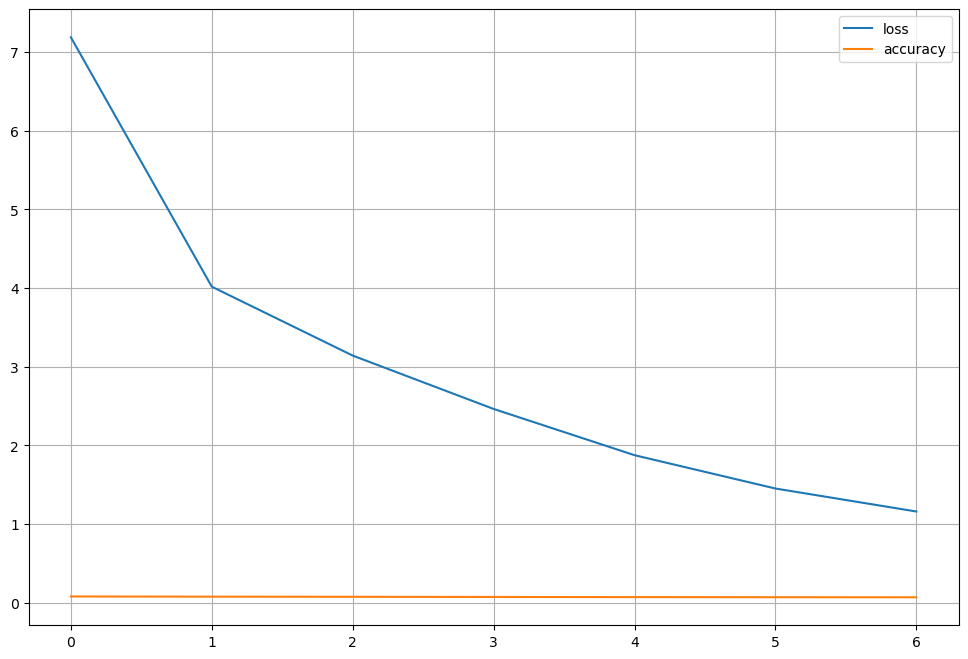

In [60]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['acc']) #정확도
plt.legend(['loss','accuracy'])
plt.grid()
plt.show()

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
def create_model(optimizer="rmsprop"):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length = max_len))
    model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same',activation = 'relu', strides = 1))
    model.add(Conv1D(filters = 32, kernel_size = 4, padding = 'same',activation = 'relu', strides = 1))
    model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same',activation = 'relu', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse', optimizer = optimizer, metrics=['acc'])
    return model

In [ ]:
neural_network = KerasClassifier(model=create_model, verbose=0)
# 하이퍼파라미터 탐색 영역을 정의
pipe=Pipeline([
    ('clf', neural_network)
    ])
params={
    'clf__epochs': [10, 50],
    'clf__batch_size': [32,64,128],
    'clf__optimizer': ["rmsprop", "adam"],
    }
grid=GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid_result = grid.fit(X, y)

In [ ]:
print(grid_result.best_params_)
print(grid_result.best_score_)